In [2]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import hashlib

## **Investigation of the Dataset**

### **Check for duplicate images**

In [19]:
def calculate_hash(file_path):
    with open(file_path, 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()
    return image_hash

In [21]:
main_folder = "dataset_raw"
classes = os.listdir(main_folder)

hash_dict = {}
duplicates = []

# Calculate hash values for each image
# Add images that are have same hash value to duplicates list

# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image_hash = calculate_hash(image_path)

        # If the same image exists, add it to the list
        if image_hash in hash_dict:
            duplicates.append((image_path, hash_dict[image_hash]))
            
        # If not add it to hash table
        else:
            hash_dict[image_hash] = image_path

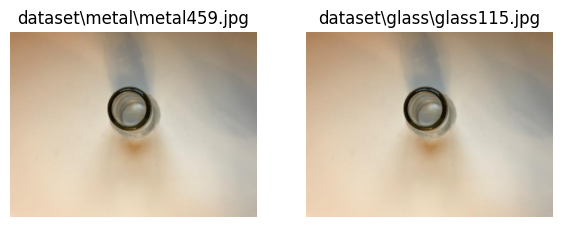

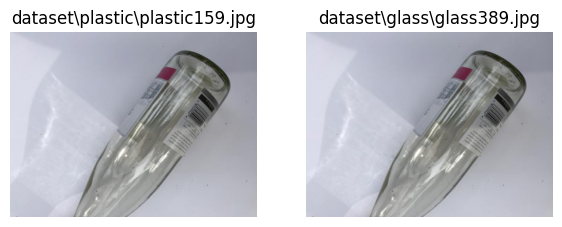

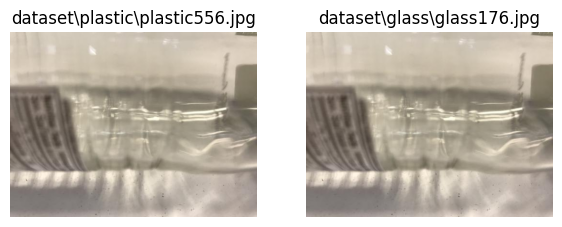

In [22]:
# Show duplicate images
for image1, image2 in duplicates:
    fig, ax = plt.subplots(1, 2, figsize=(7,7))

    # Show Image 1
    ax[0].imshow(Image.open(image1))
    ax[0].axis('off')
    ax[0].set_title(image1)

    # Show Image 2
    ax[1].imshow(Image.open(image2))
    ax[1].axis('off')
    ax[1].set_title(image2)
    
    plt.show()

According to results, removed and correct files are below:

| Correct label | Removed file |
|:--------:|:--------:|
| glass115.jpg   | metal459.jpg   |
| glass389.jpg   | plastic159.jpg |
| plastic556.jpg | glass176.jpg   |

* The misclassified duplicate files are removed by hand.

### **Class Distributions**

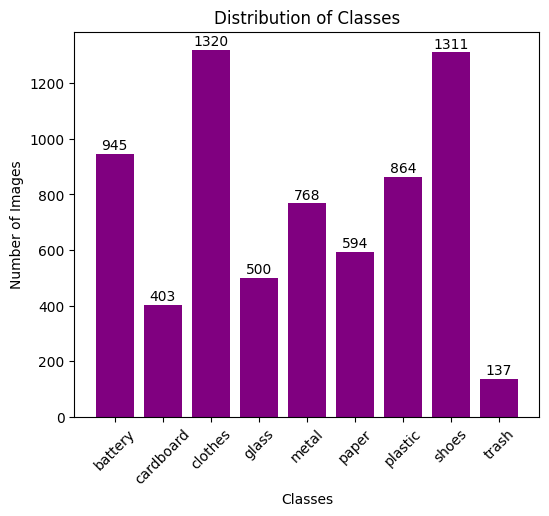

Total number of images: 6842


In [3]:
# Count the number of images for each class
class_counts = [len(os.listdir(os.path.join(main_folder, cls))) for cls in classes]

# Plot the distribution of classes
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.bar(classes, class_counts, color='purple')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Classes')
ax.set_xticks(range(len(classes)), classes, rotation=45)

# Add numbers on each bar
for i, count in enumerate(class_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

plt.show()

# Print the total number of images
print("Total number of images:", sum(class_counts))

* We now have a better distribution, but the classes remain imbalanced even after removing 1/3 of the 'clothes' class.

## **Split train and test sets**

In [4]:
X = []
y = []

# Read images and labels
# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        X.append(filename)
        y.append(class_folder)

X = np.array(X)
y = np.array(y)

# Encode y array
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split train and test sets
from sklearn.model_selection import train_test_split

# The resulting splits are stratified, which means class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

* The distribution of classes are preserved in resulting train and test sets, with using `stratify=y` parameter.

### **Save Train and Test Splits**

In [10]:
import shutil

# Create folders if does not exist
if not os.path.exists("dataset/train"):
    os.makedirs("dataset/train")
if not os.path.exists("dataset/test"):
    os.makedirs("dataset/test")

# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)

        if filename in X_train:
            shutil.copy(image_path, f"dataset/train/{filename}")

        if filename in X_test:
            shutil.copy(image_path, f"dataset/test/{filename}")

* The images are saved into location `dataset/train` and `dataset/test`

### **Class Distributions in the Train and Test Sets**

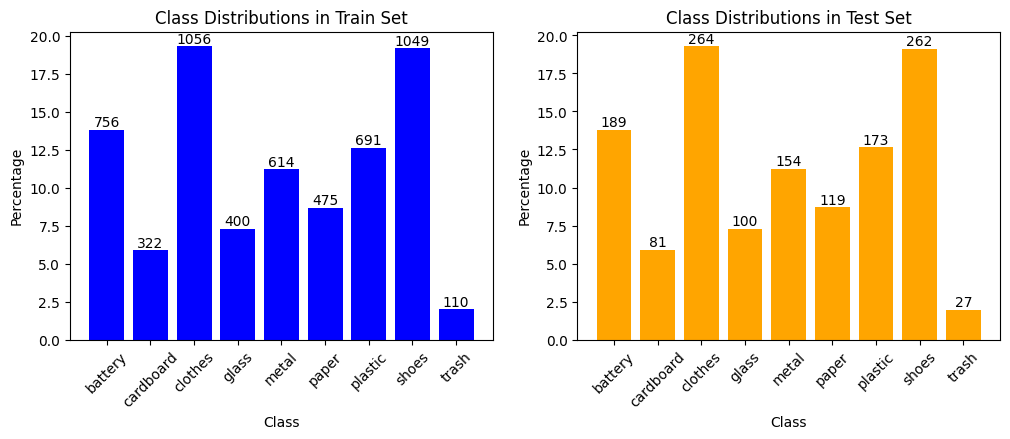

In [5]:
# Count occurrences of each class in y_train and y_test
train_counts = np.bincount(y_train, minlength=len(classes))
test_counts = np.bincount(y_test, minlength=len(classes))

# Convert counts to percentages
train_percentages = (train_counts / len(y_train)) * 100
test_percentages = (test_counts / len(y_test)) * 100

# Plot class distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot class distribution for training set
bars = ax[0].bar(classes, train_percentages, color='blue')
ax[0].bar(classes, train_percentages, color='blue')
ax[0].set_title('Class Distributions in Train Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Percentage')
ax[0].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the test set
for bar, count in zip(bars, train_counts):
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

# Plot class distribution for testing set
bars = ax[1].bar(classes, test_percentages, color='orange')
ax[1].bar(classes, test_percentages, color='orange')
ax[1].set_title('Class Distributions in Test Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Percentage')
ax[1].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the test set
for bar, count in zip(bars, test_counts):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

* The distribution of classes are same with the orginal dataset.

### **Data Augmentation on the Train Set**

In [16]:
from keras.preprocessing import image
import tensorflow as tf

train_data_dir = 'dataset/train'

# Augmentation parameters
augmentation_datagen = image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
)

# Iterate through each file in the training directory
for filename in os.listdir(train_data_dir):
    # Load the image
    img_path = os.path.join(train_data_dir, filename)
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Perform data augmentation and save augmented images
    i = 0
    for batch in augmentation_datagen.flow(img, batch_size=1):
        augmented_img = tf.keras.utils.img_to_array(batch[0])
        save_path = os.path.join(train_data_dir, f'aug_{i}_{filename}')
        
        pil_img = Image.fromarray(augmented_img.astype(np.uint8)).convert('RGB') 
        pil_img.save(save_path)

        i += 1
        # Generate three augmented images
        if i >= 3:
            break

### **Read the Splitted Dataset**

In [6]:
import io_functions

X_train, y_train = io_functions.read_data("dataset/train")
X_test, y_test = io_functions.read_data("dataset/test")

### **Number of Images After the Data Augmentation**

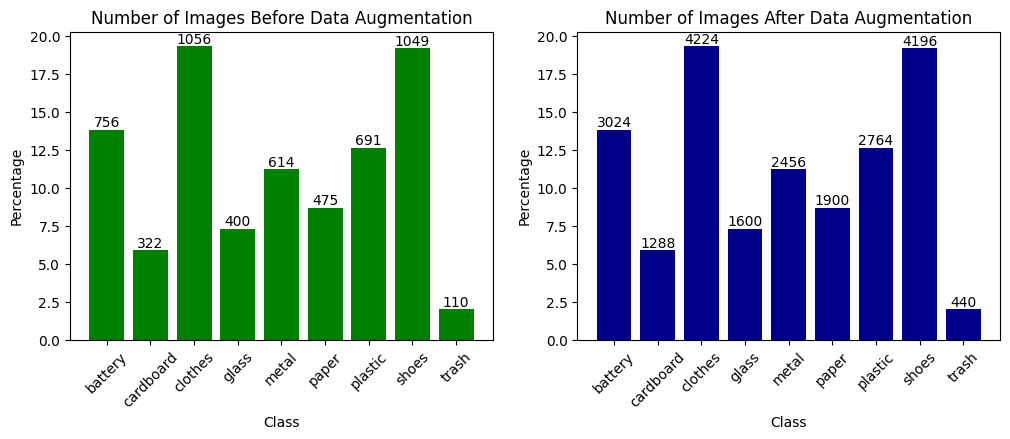

Old Train Set Size = 5473
New Train Set Size = 21892
Test Set Size = 1369


In [34]:
# Count occurrences of each class in y_train and y_test
train_counts_new = np.bincount(y_train, minlength=len(classes))

# Convert counts to percentages
train_percentages_new = (train_counts_new / len(y_train)) * 100

# Plot class distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot class distribution for old training set
bars = ax[0].bar(classes, train_percentages, color='green')
ax[0].bar(classes, train_percentages, color='green')
ax[0].set_title('Number of Images Before Data Augmentation')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Percentage')
ax[0].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the old training set
for bar, count in zip(bars, train_counts):
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

# Plot class distribution for new training set
bars = ax[1].bar(classes, train_percentages_new, color='darkblue')
ax[1].bar(classes, train_percentages_new, color='darkblue')
ax[1].set_title('Number of Images After Data Augmentation')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Percentage')
ax[1].set_xticks(range(len(classes)), classes, rotation=45)

# Add counts on top of the bars for the new training set
for bar, count in zip(bars, train_counts_new):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

print("Old Train Set Size =", np.sum(train_counts))
print("New Train Set Size =", np.sum(train_counts_new))
print("Test Set Size =", np.sum(test_counts))

* Our dataset is now prepared for utilization in machine learning algorithms.